
# Business Data Analytics Challenge: Prediction of Electricity Flows

  

Fabio Costa;  Laurin Eichberger;  Nevena Nikolajevic;  Ömer Özumerzifon;  Lukas Petry;  Hendrik Scherner  


---

## Kurze Einführung:

### Preprocessing 
Dieses Notebook im Rahmen der BDA Vorlesung hat zum Ziel, mithilfe eines Neuronalen Netzes Stromflüsse innerhalb Europa (von und nach Deutschland) vorherzusagen. 
Nach dem Einlesen der Daten werden diese zu erst bereinigt (Outlier) und skaliert. Anschließend werden Sie in ein passendes Format für das Modell geparst. Da in disesm NB ein CNN verwendet wird zur Feature Extraction, müssen die Daten pro Tag in einer `[24 x #Features]` Matrix vorliegen. Weiterhin können die 24h auch durch 48,72 etc. erweitert werden, falls pro Zeitschritt mehr als nur der letzte Tag betrachtet werden soll. 



### Modell
**1. CNN:**
Ein CNN wird zur Feature Extraction verwendet. Die Idee ist, dass die Filter-Kernel des CNNs eigenständige Features pro Zeitreihe lernt/findet, ohne dass diese Explizit angewendet werden müssen. 


**2. LSTM:**
Aufgrund der hohen auto-korrelation der einzelnen Zeitreihen, wird ein 2 stufiges LSTM verwendet, welches zeitabhängigkeiten gut abbilden kann. Das LSTM erzeugt pro Zeitschritt eine Output-Layer und erzeugt somit eine Matrix der Form `[#Zeitschritte x #Features]`. Anschließend wird mithilfe von einer Lambda Funktion der Output der letzten 24 Zeitschritte extrahiert und weitergereicht. 


**3. Dense:**
Mithilfe einer Dense Layer werden schlussendlich y_hat `[#24 x #Länder]` regressiert. 


**4. Experten Wissen:**
Innerhalb der vorangegangen Datenanalyse wurden folgende drei Punkte analysiert, welche anschließend auf y_hat angewendet wurden. 
    * Es liegen max. Kapazitäten für jede Grenze vor
    * Export>0
    * Import<0 
Dieses "Expertenwissen" wird als letzten Schritt auf y_hat angewandt. 

---

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Dense,Reshape,Dropout
from keras.layers import Input,LSTM,Lambda,Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
import keras.backend as K

from scripts.model import data_preperation as preperation
from scripts.model import model as cnn_lstm
from scripts.model import evaluation as evaluation

/Users/Schlendrikovic/Documents/Python/VirtualEnvironments/DeepLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


---

##  1. Prepare Data for CNN-LSTM

### Parameter Setting

In [137]:
# Data Parameter
aggregate = False
rolling_days = 2
use_weightes_rmse = False
evaluation_split_day = "2019-05-01"
testtraining_split_day = "2018-06-01"

# Model Parameter
dropout = 0.3
learning_rate = 1e-3
epochs = 50
batch_size = 16

use_weightes_rmse = False

### Preperation

In [3]:
logging.info('Import model data')
df = preperation.import_model_data("data/Stromfluss/",'data/additional_input.csv',aggregate)

logging.info('Enrich with daily information')
df = preperation.extract_daily_informatin(df)


# Configurations
countries = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
import_cols = [col+ "_IM" for col in countries]
export_cols = [col+ "_EX" for col in countries]

if not aggregate:
    countries = [col+ "_"+ nx_type for col in countries for nx_type in ['EX','IM']]

ind = ['Date','Tag','NX']
additional_input_columns = [col for col in df.columns  if (col not in countries) and (col not in ind) ]


logging.info('Gather maximum capacities')
export_max_capa = df[export_cols].max()
import_max_capa = df[import_cols].min()

logging.info('Remove Outlier')
df = preperation.remove_outlier(df, countries)

logging.info('Scale Data')
df,scaler = preperation.scale_data(df,countries,additional_input_columns)

logging.info('Aggregate Data for CNN')
df_nx = preperation.aggregate_nx(df, countries,rolling_days)
df_addx = preperation.aggregate_additional_input_data(df, additional_input_columns,rolling_days)

# Merge to master
df_master = pd.merge(df_nx,df_addx,on="Tag")
df_master['X_Attributes'] = df_master.apply(lambda row: np.concatenate((row.NX_per_country_shifted,row.Additional_X_aggregated),axis=1), axis=1 )
df_master.drop(['NX_per_country_shifted','Additional_X_aggregated'],axis=1,inplace=True)

Import File: DE_Physikalischer_Stromfluss_201506010000_201706012359_1.csv 
Import File: DE_Physikalischer_Stromfluss_201706020000_201906022359_1.csv 


/Users/Schlendrikovic/Documents/Python/VirtualEnvironments/DeepLearning/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Evaluation Split

In [ ]:
logging.info('Evaluation Split')
df_eval = df_master.loc[df_master.Tag>=evaluation_split_day].reset_index(drop=True)
df_master = df_master.loc[df_master.Tag<evaluation_split_day]

### Test/Training Split

In [4]:
logging.info('Test/Training Split')
test = df_master.loc[df_master.Tag>testtraining_split_day]
train = df_master.loc[df_master.Tag<=testtraining_split_day]
testX = test[['X_Attributes']].values
testY = test[['NX_per_country']].values
trainX = train[['X_Attributes']].values
trainY = train[['NX_per_country']].values

trainX, trainY, testX, testY = preperation.reformat_data_for_training(trainX, trainY, testX, testY)
print("Traings Data Shape:\n X: {} Y: {}".format(trainX.shape,trainY.shape))
print("Testing Data Shape:\n X: {} Y: {}".format(testX.shape,testY.shape))

Traings Data Shape:
 X: (1095, 1, 48, 85) Y: (1095, 24, 18)
Testing Data Shape:
 X: (333, 1, 48, 85) Y: (333, 24, 18)


---

## 2. Config and Initialize Model

In [138]:
def create_model(dropout,countries,add_x,rolling_days):
    num_features = len(countries+add_x)
    channels = 1
    InputShape = (channels,24*rolling_days,num_features)
    inputs = Input(shape=InputShape)
    
    x = inputs
    x = Conv2D(16,kernel_size=(10,1),strides=1,data_format="channels_first",padding='same')(x)
    x = Activation("relu")(x)
    x = Conv2D(1,1,data_format="channels_first")(x)
    x = Lambda(lambda x: x[:,0,:,:])(x)
    
    x = LSTM(400, return_sequences=True)(x)
    x = LSTM(400, return_sequences=True)(x)

    if rolling_days>1:
        x = Lambda(lambda x: x[:,-24::,:])(x)
    
    x = Dropout(dropout)(x)
    x = Flatten()(x)
    x = Dense(24*len(countries))(x)
    x = Reshape((24, len(countries)))(x)
    
    return Model(inputs, x)

In [139]:
weights = (np.abs(df[countries].sum())/np.abs(df[countries].sum()).sum()).values

def weighted_root_mean_squared_error(weights):
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square( (y_pred - y_true)*weights) )) 
    return root_mean_squared_error

In [141]:
model = create_model(dropout,countries,additional_input_columns,rolling_days)
opt = Adam(lr=learning_rate)

if use_weightes_rmse:
    model.compile(loss=weighted_root_mean_squared_error(weights), optimizer=opt)
else:
    model.compile(loss='mae', optimizer=opt)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
decay_schedule = lambda x: 1e-5 if x>=25 else 1e-4 if x>=15 else learning_rate
ls = LearningRateScheduler(decay_schedule,verbose=1)

---

## 3. Train Model

In [142]:
logging.info('Train Model')
train_history = model.fit(
    trainX, 
    trainY,
    validation_data=(testX, testY),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es, mc,ls]
)

Train on 1095 samples, validate on 333 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/50
1088/1095 [============================>.] - ETA: 0s - loss: 0.1598
Epoch 00001: val_loss improved from inf to 0.13349, saving model to best_model.h5
1095/1095 [==============================] - 58s 53ms/step - loss: 0.1596 - val_loss: 0.1335

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/50
1088/1095 [============================>.] - ETA: 0s - loss: 0.1113
Epoch 00002: val_loss improved from 0.13349 to 0.12596, saving model to best_model.h5
1095/1095 [==============================] - 50s 46ms/step - loss: 0.1113 - val_loss: 0.1260

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/50
1088/1095 [============================>.] - ETA: 0s - loss: 0.1024
Epoch 00003: val_loss improved from 0.12596 to 0.11865, saving model to best_model.h5
1095/1095 [==============================] - 54s 49ms/step - loss: 0.

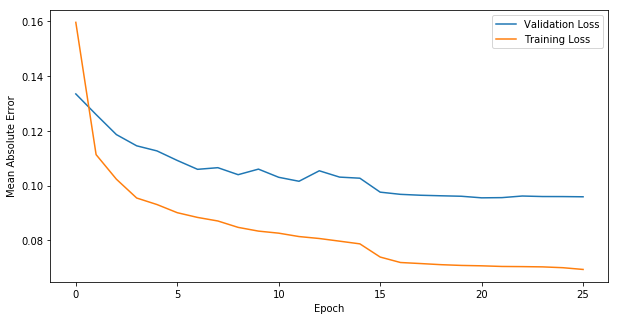

In [143]:
cnn_lstm.plot_train_history(train_history)

---

## 4. Evaluate Model

In [144]:
logging.info("Evaluation")

if use_weightes_rmse:
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square( (y_pred - y_true)*weights) )) 

    model = load_model('best_model.h5',custom_objects={
        'weighted_root_mean_squared_error':weighted_root_mean_squared_error,
        'root_mean_squared_error' : root_mean_squared_error
    })
else:
    model = load_model('best_model.h5')

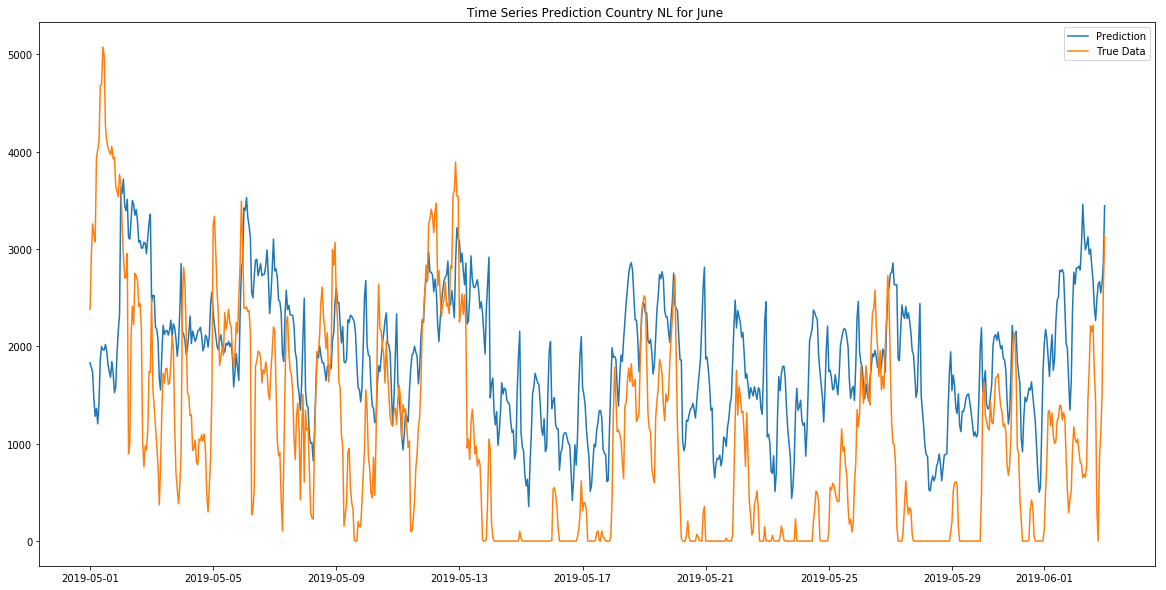

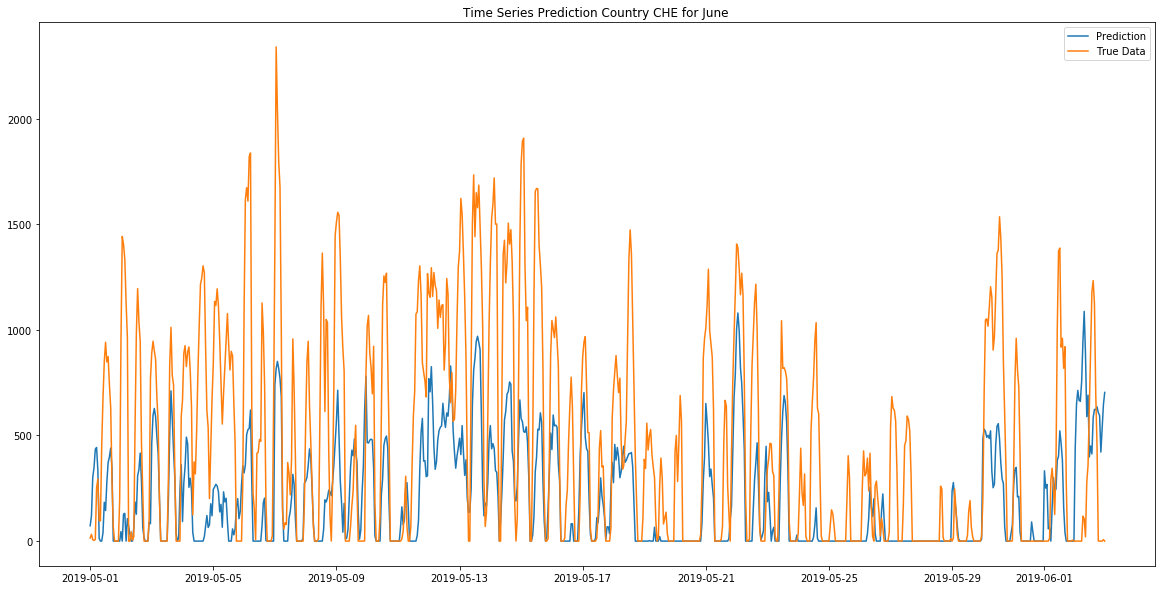

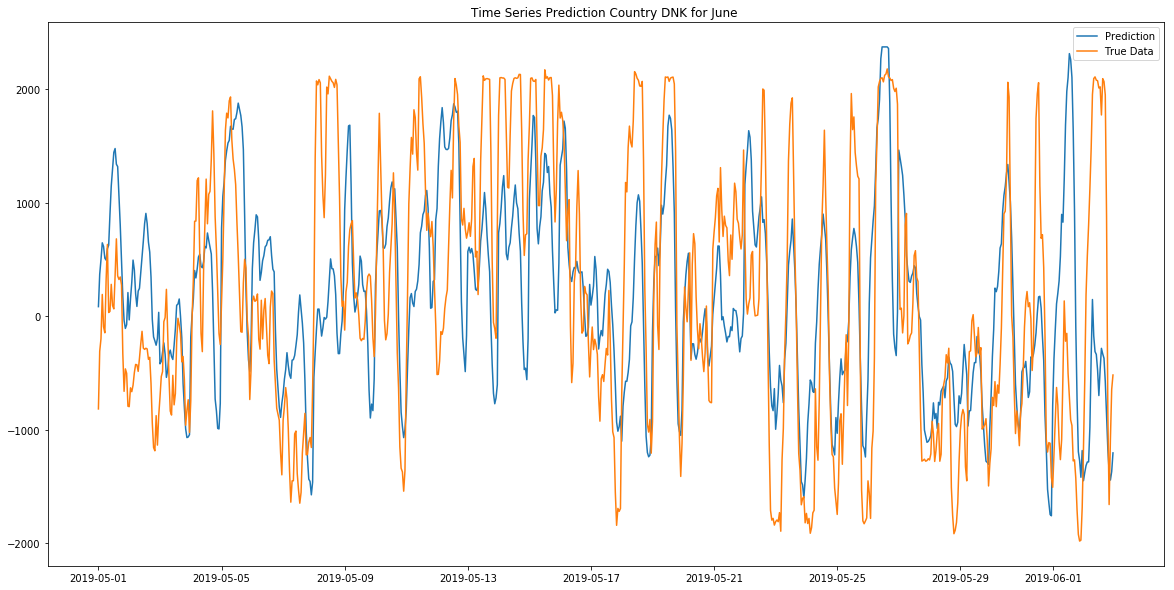

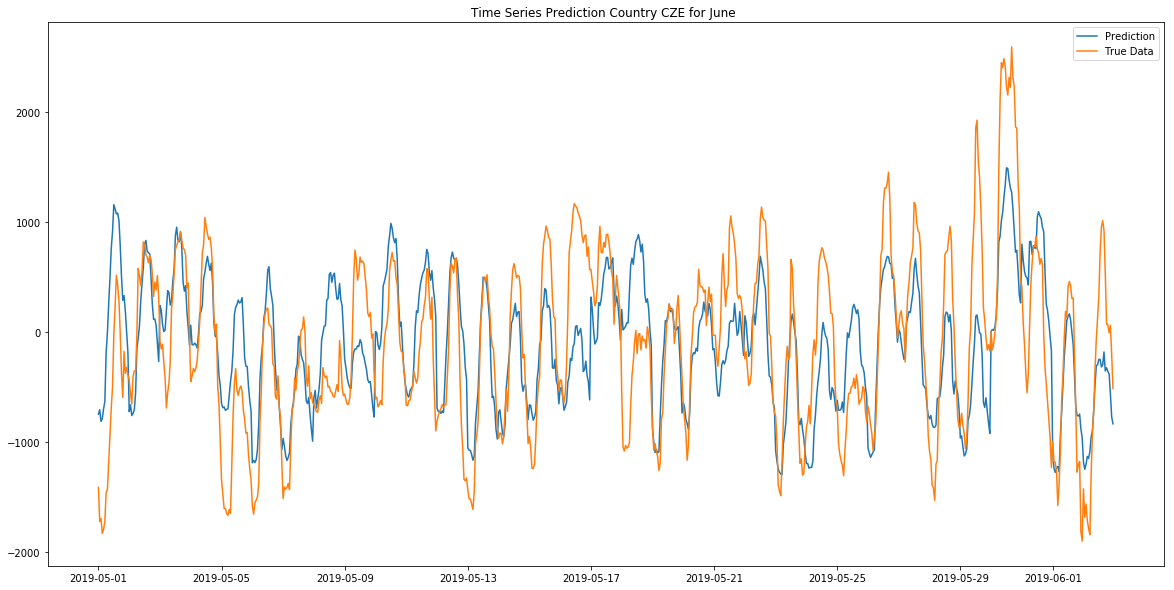

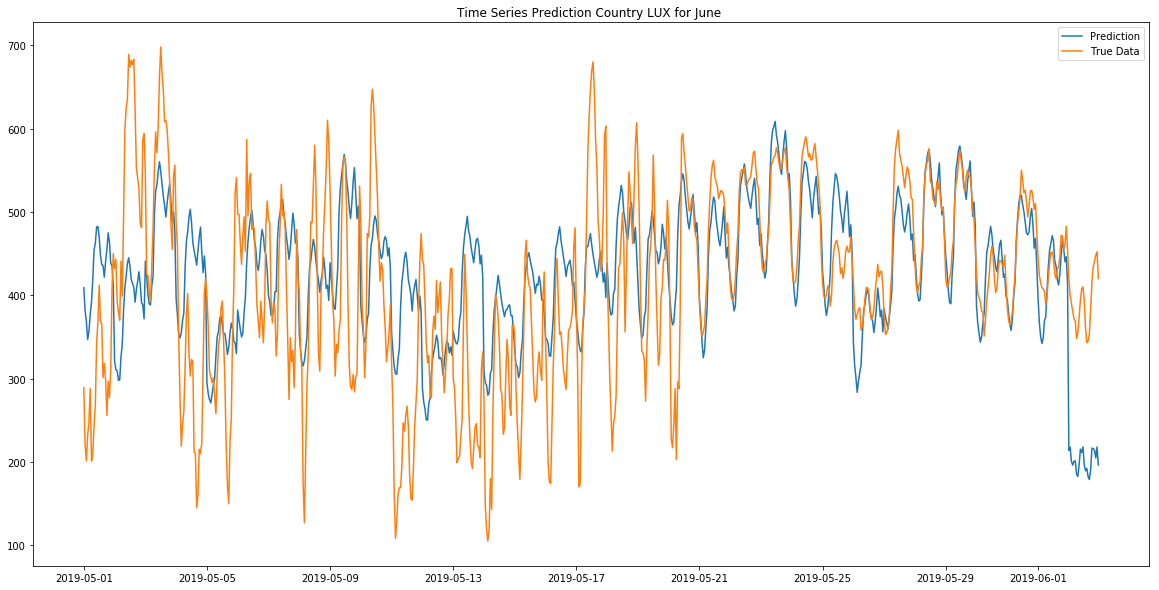

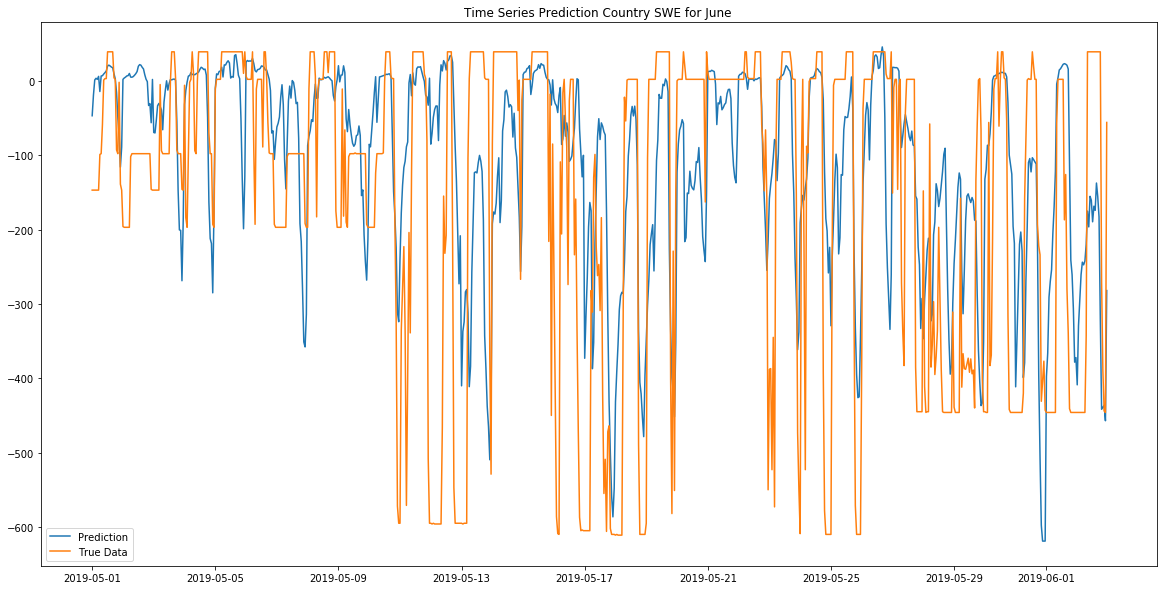

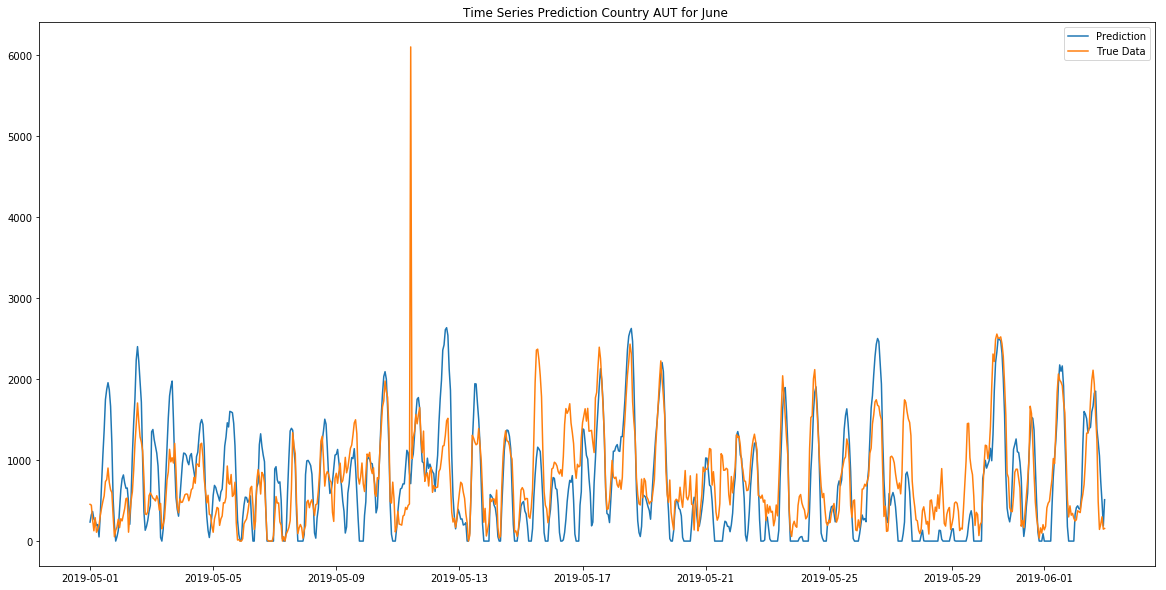

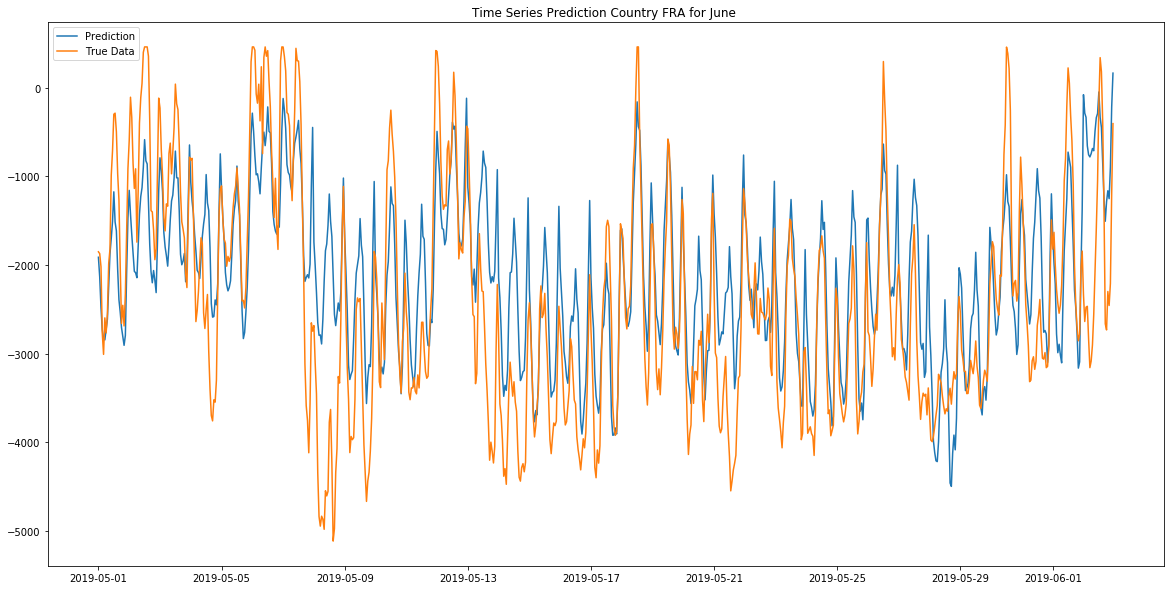

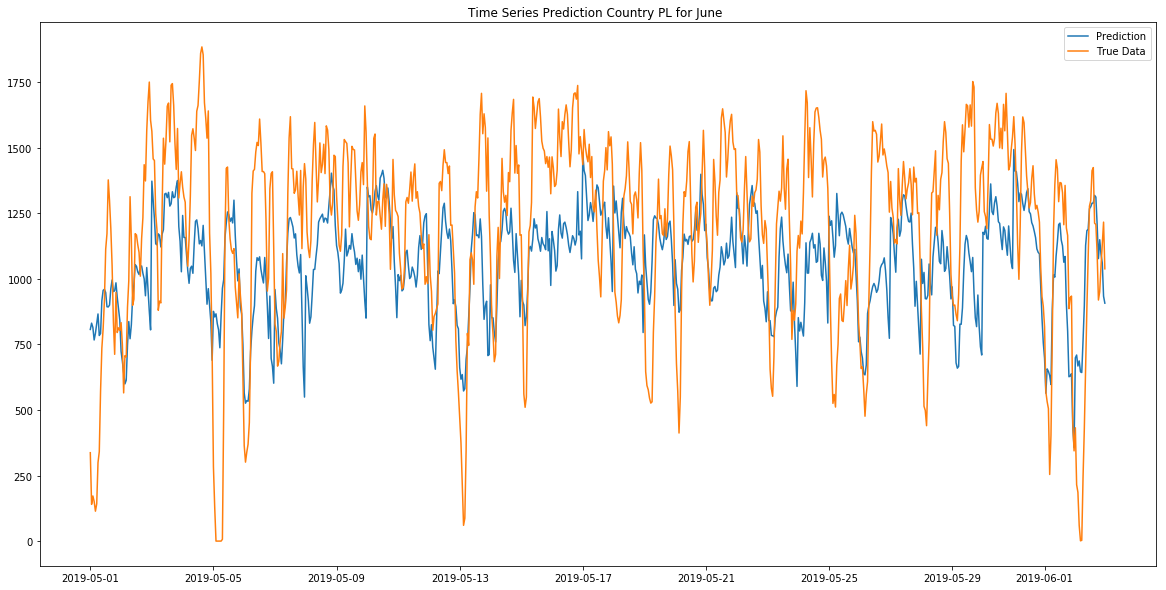

MAE:
NL     1050.788803
CHE     334.458471
DNK     751.976679
CZE     442.250942
LUX      74.155608
SWE     132.385148
AUT     354.585666
FRA     664.608242
PL      273.197347
dtype: float64

Gesamt:453.15632272154824


In [145]:
aggregate_prediction = True

df_predictions , df_true_eval_values = evaluation.predict(model,df_eval,countries)
df_predictions[countries] = scaler.inverse_transform(df_predictions[countries])
df_true_eval_values[countries] = scaler.inverse_transform(df_true_eval_values[countries])

df_predictions = evaluation.apply_expert_knowledge(df_predictions,import_cols,export_cols,import_max_capa,export_max_capa)

if aggregate_prediction:
    cols = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
    df_predictions , df_true_eval_values = evaluation.aggregate_to_country(df_predictions, df_true_eval_values)
    evaluation.plot_and_calculate_error(df_predictions,df_true_eval_values,cols)      
else:
    evaluation.plot_and_calculate_error(df_predictions,df_true_eval_values,countries)
    

In [146]:
error_scale = np.abs(df_true_eval_values.sum())/np.abs(df_true_eval_values.sum()).sum()

rmse = np.sqrt(((df_true_eval_values[cols].values - df_predictions[cols].values)**2).mean(axis=0))
weighted_rmse = (error_scale * rmse).sum()
print("Weighted RMSE: {}".format(weighted_rmse))

Weighted RMSE: 689.275830327094


---

In [147]:
df_predictions.to_csv('df_predictions.csv',sep=";",index=True)
df_true_test_values.to_csv('df_true_test_values.csv',sep=";",index=True)

----